# **TA #3 - Python version**

## Foundation of Econometrics - DSDM 2025-2026

**Lucia Sauer**

**Contact:** [lucia.sauer@bse.eu](mailto:lucia.sauer@bse.eu)

In this notebook we will review:

1. Regression Analysis
2. Standard Error Calculation
3. Hypothesis Testing
4. Stargazer


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from stargazer.stargazer import Stargazer  
import wooldridge as woo

sns.set(style="whitegrid", context="talk")

## **1. Regression Analysis**
---

- The `bwght` dataset contains information on 1,388 births in the United States.

- It was collected to study the determinants of infant birth weight, particularly the effects of maternal smoking and socioeconomic factors during pregnancy.


In [2]:
df = woo.data('bwght')
df = df.dropna()
df.sample(5)

,faminc,cigtax,cigprice,bwght,fatheduc,motheduc,parity,male,white,cigs,lbwght,bwghtlbs,packs,lfaminc
15,17.5,16.5,122.300003,122,13.0,13.0,1,1,1,0,4.804021,7.6250,0.0,2.862201
581,22.5,26.0,148.600006,120,18.0,18.0,1,1,0,0,4.787492,7.5000,0.0,3.113515
1232,65.0,26.0,137.000000,131,18.0,12.0,1,0,1,12,4.875197,8.1875,0.6,4.174387
626,32.5,25.0,133.000000,138,11.0,11.0,2,0,1,0,4.927254,8.6250,0.0,3.481240
392,47.5,20.0,132.699997,127,16.0,16.0,1,1,1,0,4.844187,7.9375,0.0,3.860730




$$\texttt{bwght}_i = \beta_1 + \beta_2 \texttt{cigs}_i + \beta_3 \texttt{parity}_i + \beta_4 \texttt{faminc}_i + \beta_5 \texttt{motheduc}_i + \beta_6 \texttt{fatheduc}_i + \epsilon_i$$

where:

- $\texttt{bwght}$: birth weight, in pounds; 
- $\texttt{cigs}$: average number of cigarettes the mother smoked per day during pregnancy; 
- $\texttt{parity}$: birth order of the child; 
- $\texttt{faminc}$: annual family income; 
- $\texttt{motheduc}$: years of schooling of the mother; 
- $\texttt{fatheduc}$: years of schooling of the father.

In [3]:
X = sm.add_constant(df[['cigs', 'parity', 'faminc', 'motheduc', 'fatheduc']])
model = sm.OLS(df['bwght'], X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  bwght   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     9.553
Date:                Fri, 10 Oct 2025   Prob (F-statistic):           5.99e-09
Time:                        11:13:08   Log-Likelihood:                -5242.2
No. Observations:                1191   AIC:                         1.050e+04
Df Residuals:                    1185   BIC:                         1.053e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.5243      3.728     30.716      0.0

## **Standard Error Calculation**
---

How does the $se(\hat{\beta}_2)$ is calculated?

$$se(\hat{\beta}_2)=\sqrt{\hat{\sigma}^2(\mathbf{X}'\mathbf{X})^{-1}_{22}}$$

where:

- $\hat{\sigma}^2 = \frac{1}{n-K} \hat{\epsilon}'\hat{\epsilon}$ is the estimator of the variance of the error term.
- $(\mathbf{X}'\mathbf{X})^{-1}_{22}$ is the second diagonal element of the inverse of the matrix $\mathbf{X}'\mathbf{X}$, which captures the variance of $\texttt{cigs}$ conditional on all other regressors.


In [4]:
#sum squared of the errors or residuals
sse = model.ssr

XtX = np.dot(X.T, X)
XtX_inv = np.linalg.inv(XtX)
round(XtX_inv[1,1],4) # This is (X'X)^{-1}_{22}

n_k = model.df_resid  # n - K
se_beta2 = np.sqrt((sse/n_k) * XtX_inv[1,1])
round(se_beta2,4)

np.float64(0.1103)

## **2. Hypothesis Testing**
---

### **2.1 Two-sided test**

Test whether $\texttt{cigs}$ has no effect on the $\texttt{bwght}$

$$H_0: \beta_2 = 0 $$
$$H_1: \beta_2 \neq 0 $$

using the t-test statistic. This test is called two-sided test since its rejection region is in both tails of the distribution.

In [39]:
t = stats.t
print(f"t observed: {model.tvalues['cigs']:.2f}")
print(f"t critical (α=0.05): ±{t.ppf(0.975, model.df_resid):.2f}")

t observed: -5.40
t critical (α=0.05): ±1.96


### Rejection and acceptance regions

Under H0

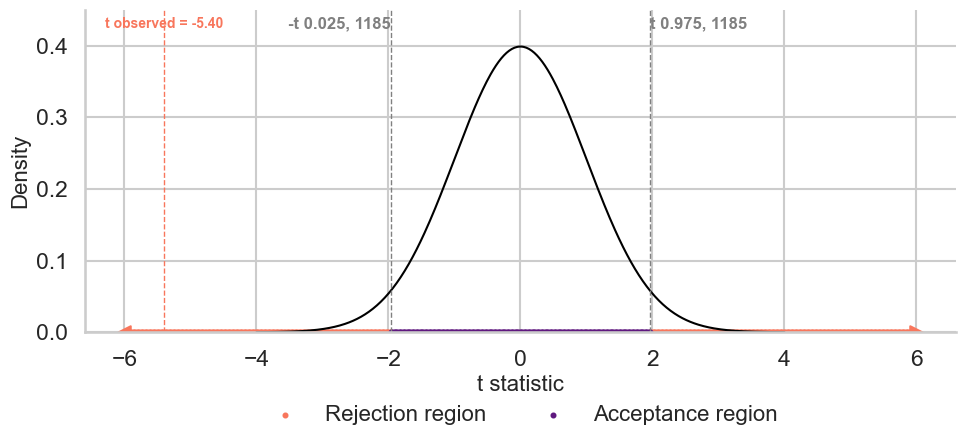

In [41]:
# --- Data ---
t = stats.t
dfree = model.df_resid
t_val = model.tvalues['cigs']
t_crit = t.ppf(0.975, dfree)

x = np.linspace(-4, 4, 400)
y = t.pdf(x, dfree)

palette = sns.color_palette("magma", as_cmap=False)

# --- Create figure and axes ---
fig, ax = plt.subplots(figsize=(10,5))

# --- Base plot ---
ax.plot(x, y, color='black', lw=1.5)
ax.set_ylim(0, 0.45)

# --- Define regions ---
reject_left = np.linspace(-6, -t_crit, 200)
reject_right = np.linspace(t_crit, 6, 200)
accept = np.linspace(-t_crit, t_crit, 200)

# --- Rejection regions (red points) ---
ax.scatter(reject_left, np.zeros_like(reject_left), color=palette[4], s=8, label='Rejection region')
ax.scatter(reject_right, np.zeros_like(reject_right), color=palette[4], s=8)
ax.scatter([-6], [0], color=palette[4], s=80, marker='<')
ax.scatter([6], [0], color=palette[4], s=80, marker='>')

# --- Acceptance region (green points) ---
ax.scatter(accept, np.zeros_like(accept), color=palette[1], s=8, label='Acceptance region')

# --- Observed t statistic ---
#ax.scatter([t_val], [0], color=palette[2], s=40, label=f't observed = {t_val:.2f}', zorder=5)
ax.axvline(x=t_val, color=palette[4], linestyle='--', lw=1)

# --- Critical value lines ---
ax.axvline(x=-t_crit, color='gray', linestyle='--', lw=1)
ax.axvline(x=t_crit, color='gray', linestyle='--', lw=1)

# --- Add labels above critical values ---
ax.text(-t_crit, 0.42, f"-t 0.025, 1185", 
        ha='right', va='bottom', color='gray', fontsize=12, fontweight='bold')
ax.text(t_crit, 0.42, f"t 0.975, 1185", 
        ha='left', va='bottom', color='gray', fontsize=12, fontweight='bold')
        
# --- Label observed t statistic ---
ax.text(t_val, 0.42, f't observed = {t_val:.2f}', color=palette[4], fontsize=10,
        ha='center', va='bottom', fontweight='bold')

# --- Spines and ticks formatting ---
sns.despine(ax=ax)


# --- Labels and legend ---
ax.set_xlabel("t statistic", fontsize=16)
ax.set_ylabel("Density", fontsize=16)
ax.legend(frameon=False, loc='lower center', fontsize=16, ncol=3, bbox_to_anchor=(0.5, -0.35))
plt.tight_layout()
plt.grid(True)
plt.show()


### p-value

The p-value is calculated as follows:

$$p-value = prob\{|t-statistic|> -5.40| H0\}$$

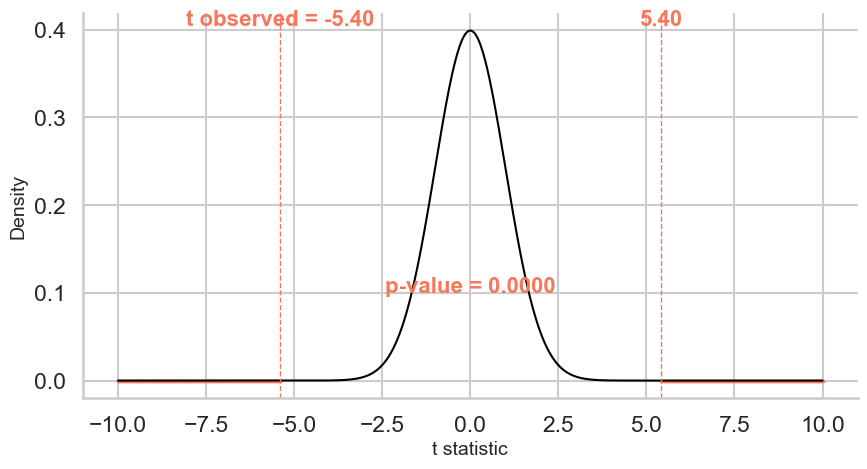

In [40]:
# --- Datos ---
dfree = 1191-6          # degrees of freedom example
t_val_left = -5.40  # left limit
t_val_right = 5.40  # right limit
t_dist = stats.t

# --- Grid for the curve ---
x = np.linspace(-10, 10, 1000)  
y = t_dist.pdf(x, dfree)

# --- Create figure ---
fig, ax = plt.subplots(figsize=(10,5))

# --- Curve t ---
ax.plot(x, y, color='black', lw=1.5)

# --- Shade left area (from -∞ to t_val_left) ---
x_left = x[x <= t_val_left]
ax.fill_between(x_left, 0, t_dist.pdf(x_left, dfree), color=palette[4], alpha=0.5)

# --- Shade right area (from t_val_right to +∞) ---
x_right = x[x >= t_val_right]
ax.fill_between(x_right, 0, t_dist.pdf(x_right, dfree), color=palette[4], alpha=0.5)

ax.scatter(x_right, np.zeros_like(x_right), color=palette[4], s=1)
ax.scatter(x_left, np.zeros_like(x_left), color=palette[4], s=1)

# --- Vertical lines with t observed ---
ax.axvline(t_val_left, color=palette[4], linestyle='--', lw=1)
ax.axvline(t_val_right, color=palette[4], linestyle='--', lw=1)
ax.text(t_val_left, 0.4, f"t observed = {t_val_left:.2f}", color=palette[4], fontsize=16, ha='center', va='bottom', fontweight='bold')
ax.text(t_val_right, 0.4, f"{t_val_right:.2f}", color=palette[4], fontsize=16, ha='center', va='bottom', fontweight='bold')


# --- Labels ---
ax.set_xlabel("t statistic", fontsize=14)
ax.set_ylabel("Density", fontsize=14)


# --- Annotate p-value ---
p_value = 2 * t_dist.cdf(t_val_left, dfree)  # two-tailed p-value
ax.text(0, 0.1, f"p-value = {p_value:.4f}", fontsize=16, ha='center', color=palette[4], fontweight='bold')

sns.despine()
plt.show()


### **2.3 Multiple test**

Test whether $\texttt{fatheduc}$ or $\texttt{motheduc}$ has no effect on the $\texttt{bwght}$

$$H_0: \beta_5 = \beta_6 = 0 $$
$$H_1: Not \ H0 $$

using the F statistic.

Under H0, the statistict for this is test is given by and follows an F-distribution with $q$ and $n-K$ degrees of freedom:



$$F = \frac{(RSSE - SSE)/q}{SSE/(n-k)} \stackrel{Under H_0}{\sim} F_{q, n-k}$$

In [6]:
X_restricted = sm.add_constant(df[['cigs', 'parity', 'faminc']])
model_restricted = sm.OLS(df['bwght'], X_restricted).fit()
sse_restricted = model_restricted.ssr
sse_restricted

np.float64(465166.7921270099)

In [44]:
f_observed = ((sse_restricted - sse) / 2) / (sse / (1185))
#pvalue
f_observed, 1 - stats.f.cdf(f_observed, 2, 1185)

(np.float64(1.4372686389750604), np.float64(0.23798962194788897))

In [45]:
f_critical = stats.f.ppf(0.95, 2, 1185)
f_critical

np.float64(3.003318396872078)

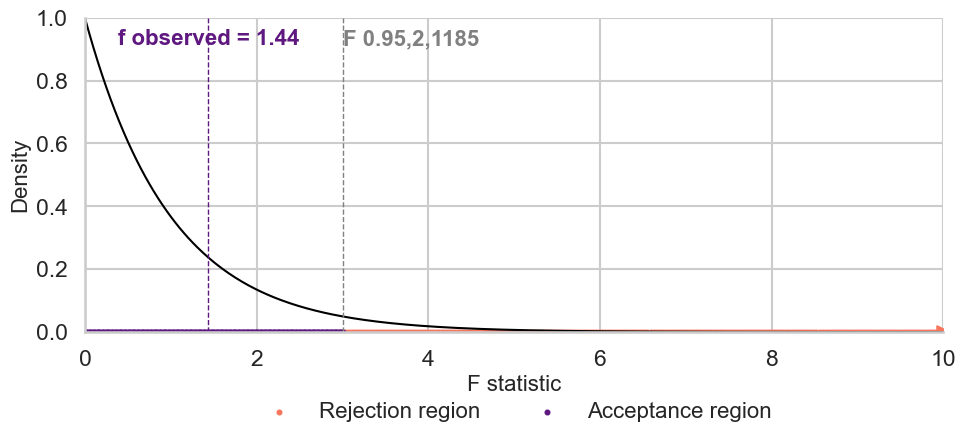

In [49]:
# --- Data ---
dfree1 = 2          # degrees of freedom numerator
dfree2 = 1191-6     # degrees of freedom denominator
f_val = 1.437  # observed F value
f_crit = stats.f.ppf(0.95, dfree1, dfree2)
x = np.linspace(0, 10, 400)
y = stats.f.pdf(x, dfree1, dfree2)
# --- Create figure and axes ---
fig, ax = plt.subplots(figsize=(10,5))
# --- Base plot ---
ax.plot(x, y, color='black', lw=1.5)
ax.set_ylim(0, 1)
ax.set_xlim(0, 10)
# --- Define regions ---
reject = np.linspace(f_crit, 10, 200)
accept = np.linspace(0, f_crit, 200)
# --- Rejection region (red points) ---
ax.scatter(reject, np.zeros_like(reject), color=palette[4], s=8, label='Rejection region')
ax.scatter([10], [0], color=palette[4], s=80, marker='>')
# --- Acceptance region (green points) ---
ax.scatter(accept, np.zeros_like(accept), color=palette[1], s=8, label='Acceptance region')

# --- Critical value line ---
ax.axvline(x=f_crit, color='gray', linestyle='--', lw=1)
# --- Add label above critical value ---
ax.text(f_crit, 0.9, f"F 0.95,2,1185", 
        ha='left', va='bottom', color='gray', fontsize=16, fontweight='bold')


ax.axvline(x=f_val, color=palette[1], linestyle='--', lw=1)       
# --- Label observed F statistic ---
ax.text(f_val, 0.9, "f observed = 1.44", color=palette[1], fontsize=16, ha='center', va='bottom', fontweight='bold')
# --- Spines and ticks formatting ---
sns.despine()
# --- Labels and legend ---
ax.set_xlabel("F statistic", fontsize=16)
ax.set_ylabel("Density", fontsize=16)
#in the bottom center
ax.legend(frameon=False, loc='lower center', fontsize=16, ncol=3, bbox_to_anchor=(0.5, -0.35))
plt.tight_layout()
plt.grid(True)
plt.show()


The p-value is calculated as follows:

$$p-value = prob\{F-statistic> 3| H0\}$$


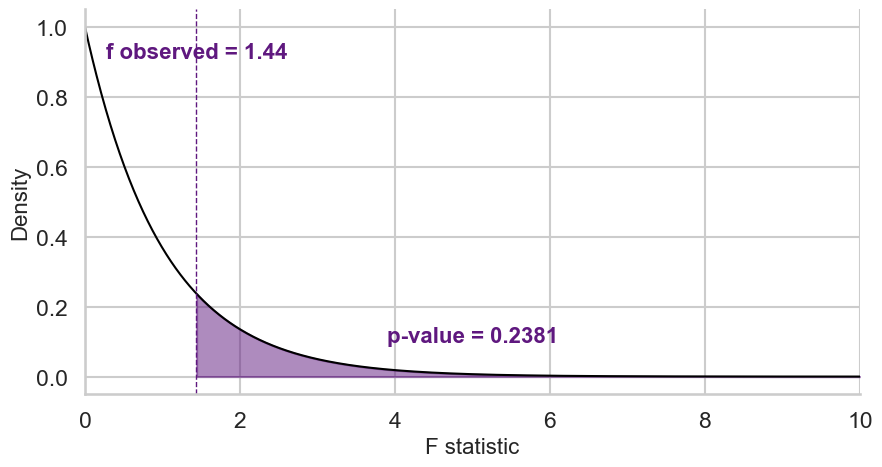

In [48]:
# --- Datos ---
dfree1 = 2          # degrees of freedom numerator
dfree2 = 1191-6     # degrees of freedom denominator
f_val = 1.437  # observed F value
f_dist = stats.f
# --- Grid for the curve ---
x = np.linspace(0, 10, 1000)
y = f_dist.pdf(x, dfree1, dfree2)
# --- Create figure ---
fig, ax = plt.subplots(figsize=(10,5))
# --- Curve F ---
ax.plot(x, y, color='black', lw=1.5)

ax.set_xlim(0, 10)
# --- Shade area (from f_val to +∞) ---
x_right = x[x >= f_val]
ax.fill_between(x_right, 0, f_dist.pdf(x_right, dfree1, dfree2), color=palette[1], alpha=0.5)
# --- Vertical line with F observed ---
ax.axvline(f_val, color=palette[1], linestyle='--', lw=1)
ax.text(f_val, 0.9, f"f observed = {f_val:.2f}", color=palette[1], fontsize=16, ha='center', va='bottom', fontweight='bold')

# --- Labels ---
ax.set_xlabel("F statistic", fontsize=16)
ax.set_ylabel("Density", fontsize=16)
# --- Annotate p-value ---
p_value = 1 - f_dist.cdf(f_val, dfree1, dfree2)  # p-value
ax.text(5, 0.1, f"p-value = {p_value:.4f}", fontsize=16, ha='center', color=palette[1], fontweight='bold')
sns.despine()
plt.show()

## **3. Export results to LaTex**
---

This will export a <code>.tex</code> file that will contain the code ready to upload to our LaTex project.

In [50]:
# Export the LaTeX code to a .tex file
stargazer = Stargazer([model])
with open("regression_output.tex", "w") as f:
    f.write(stargazer.render_latex())

#Print the LaTe code
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable: bwght}} \
\cr \cline{2-2}
\\[-1.8ex] & (1) \\
\hline \\[-1.8ex]
 cigs & -0.596$^{***}$ \\
& (0.110) \\
 const & 114.524$^{***}$ \\
& (3.728) \\
 faminc & 0.056$^{}$ \\
& (0.037) \\
 fatheduc & 0.472$^{*}$ \\
& (0.283) \\
 motheduc & -0.370$^{}$ \\
& (0.320) \\
 parity & 1.788$^{***}$ \\
& (0.659) \\
\hline \\[-1.8ex]
 Observations & 1191 \\
 $R^2$ & 0.039 \\
 Adjusted $R^2$ & 0.035 \\
 Residual Std. Error & 19.789 (df=1185) \\
 F Statistic & 9.553$^{***}$ (df=5; 1185) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}
